# **Import Necessary Libraries**

In [33]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import re
import string
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, f1_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


# **Data Loading**

In [3]:
train_df  = pd.read_csv('../Twitter_Sentiment_Analysis_Project/Corona_NLP_train.csv',encoding='ISO-8859-1')
test_df = pd.read_csv('../Twitter_Sentiment_Analysis_Project/Corona_NLP_test.csv')

In [4]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
train_df.shape

(41157, 6)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Check for duplicated data

In [7]:
train_df.duplicated().values.any()

False

Check for null data

In [8]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    Percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, Percentage], axis=1, keys=['Total', 'Percentage'])

missing_data(train_df)


,Total,Percentage
Location,8590,20.871298
UserName,0,0.000000
ScreenName,0,0.000000
TweetAt,0,0.000000
OriginalTweet,0,0.000000
Sentiment,0,0.000000


# **Exploratory Data Analysis**

In [9]:
sent_per = pd.DataFrame(data=train_df.groupby('Sentiment').size()/train_df['UserName'].count()*100,columns=['Percentage']).reset_index()
sent_per


,Sentiment,Percentage
0,Extremely Negative,13.317297
1,Extremely Positive,16.094468
2,Negative,24.095537
3,Neutral,18.740433
4,Positive,27.752266


In [10]:
order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

fig = px.bar(
    sent_per, 
    x='Sentiment', 
    y='Percentage', 
    color='Sentiment',
    title='Percentage of Twitter Sentiment',
    labels={'Sentiment': 'Sentiment', 'Percentage': 'Percentage (%)'},
    text='Percentage'
)

fig.update_layout(
    xaxis_title='Sentiment',
    yaxis_title='Percentage (%)',
    xaxis=dict(
        categoryorder='array',
        categoryarray=order
    ),
    yaxis=dict(
        range=[0, 30] 
    ),
    template='plotly_dark'
)

fig.update_traces(
    texttemplate='%{text:.2f}%',
    textposition='outside',
    textfont=dict(size=12, color='white')
)

fig.show()

In [11]:
train_df['TweetAt'] = pd.to_datetime(train_df['TweetAt'])

tweet_counts = train_df.groupby('TweetAt').size().reset_index(name='TweetCount')

fig = px.line(tweet_counts, x='TweetAt', y='TweetCount', title='Daily Tweet Count Over Time')

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Tweet Count',
    template='plotly_dark'  
)

fig.show()

In [12]:
tweets_per_location = train_df['Location'].value_counts().loc[lambda x:x>100].reset_index(name='counts')
tweets_per_location

,Location,counts
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


In [13]:
def categorize_country(location):
    if 'London' in location:
        return 'United Kingdom'
    elif 'United Kingdom' in location:
        return 'United Kingdom'
    elif 'UK' in location:
        return 'United Kingdom'
    elif 'India' in location:
        return 'India'
    elif 'Toronto' in location:
        return 'Canada'
    elif 'Canada' in location:
        return 'Canada'
    elif 'Australia' in location:
        return 'Australia'
    elif 'Global' in location:
        return 'Worldwide'
    elif 'Worldwide' in location:
        return 'Worldwide'
    else:
        return 'United States'
    

In [14]:
tweets_per_location['Country'] = tweets_per_location['Location'].apply(categorize_country)
tweet_counts__per_country = tweets_per_location.groupby('Country', as_index=False)['counts'].sum()

fig = px.bar(
    tweet_counts__per_country, 
    x='Country', 
    y='counts', 
    color='Country',
    title='Tweet Count by Country',
    labels={'Country': 'Country', 'counts': 'Count'},
    text='counts'
)

fig.update_layout(
    xaxis_title='Country',
    yaxis_title='Count',
    yaxis=dict(
        range=[0, 3000] 
    ),
    template='plotly_dark'
)

fig.update_traces(
    texttemplate='%{text}',
    textposition='outside',
    textfont=dict(size=12, color='white')
)

fig.show()

# **Text Preprocessing**

Remove HTML tags

In [15]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub('', text)

Remove URLs

In [16]:
def remove_url(text):
    pattern=re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',text)

Remove punctuations

In [17]:
exclude=string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('','',exclude))

Remove stopwords

In [18]:
def remove_stopwords(text):
    new_text=[]
    for word in text.split():
        if word in stopwords.words('english'):
            new_text.append('')
        else:
            new_text.append(word)
            
    x=new_text[:]
    new_text.clear()
    return " ".join(x)

Remove non-english word

In [19]:
nltk.download('words')

english_words = set(words.words())

def remove_non_english_words(text):
    word_list = re.findall(r'\b\w+\b', text)

    filtered_words = [word for word in word_list if word.lower() in english_words]
    
    return ' '.join(filtered_words)

[nltk_data] Downloading package words to
[nltk_data]     /Users/suntaetangsatgatham/nltk_data...
[nltk_data]   Package words is already up-to-date!


Remove emojis

In [20]:
def remove_emoji(text):
    emoji_pattern=re.compile("["
                             u"\U0001F600-\U0001F64F" #emoticons
                             u"\U0001F300-\U0001F5FF" #symbols, pictograph
                              u"\U0001F680-\U0001F6FF" #transport and map symbol
                              u"\U0001F1E0-\U0001F1FF" # flags(IOS)
                              u"\U00002702-\U000027B0"
                              u"\U00002FC2-\U0001F251"
                             "]+",flags=re.UNICODE)
    return emoji_pattern.sub(r'',text)

Stemming

In [21]:
ps=PorterStemmer()
def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])

Create a text cleaning function

In [22]:
def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    text = remove_url(text)
    text = remove_punc(text)
    text = remove_stopwords(text)
    text = remove_non_english_words(text)
    text = remove_emoji(text)
    text = stem_words(text)
    return text

Apply function on text variables and handle dependent variable

In [23]:
train_df['Cleaned_Text'] = train_df['OriginalTweet'].apply(clean_text)
test_df['Cleaned_Text'] = test_df['OriginalTweet'].apply(clean_text)

train_df = train_df[train_df['Cleaned_Text'] != '']
test_df = test_df[test_df['Cleaned_Text'] != '']

train_df['Sentiment_Flag'] = train_df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
test_df['Sentiment_Flag'] = test_df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

X = train_df['Cleaned_Text']
y = train_df['Sentiment_Flag']
X_test = test_df['Cleaned_Text']
y_test = test_df['Sentiment_Flag']

Split data into train and validation set, then fit_transform with TF-IDF

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(smooth_idf=True)

X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)
X_test_tfidf = tfidf.transform(X_test)

To address the imbalance dataset, oversampling is used to increase the number of neutral tweets to match the number of negative and positive tweets. In this process, SMOTE (Synthetic Minority Over-sampling Technique) is employed to generate synthetic data points for the minority class.

In [25]:
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train_tfidf, y_train)

# **Model Selection and Tuning**

In [34]:
models = {
    'LogisticRegression': LogisticRegression(),
    'MultinomialNB': MultinomialNB(),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

param_grids = {
    'LogisticRegression': {},
    'MultinomialNB': {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
    },
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 30],
        'min_samples_split': [2, 5, 10],
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 10]
    }   
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

# **Model Training**

GridSearchCV and KFold are being used to train data multiple times and return the best parameters for every models for selection

##### Machine Learning Models

In [36]:
grids = {}
for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv,scoring='roc_auc_ovr_weighted', n_jobs=-1, verbose=1)
    grids[model_name].fit(X_train_sm, y_train_sm)
    
    y_train_pred = grids[model_name].predict(X_train_sm)
    
    best_params = grids[model_name].best_params_
    best_score = grids[model_name].best_score_

    acc = accuracy_score(y_train_sm, y_train_pred)
    f1 = f1_score(y_train_sm, y_train_pred, average='micro')
    
    print(f'Best Parameters for {model_name}: {best_params}')
    print(f'Best ROC AUC Score: {best_score}')
    print(f'Accuracy Score: {acc}')
    print(f'F1 Score: {f1}\n')

Training and tuning LogisticRegression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/suntaetangsatgatham/suntae/portfolio/kaggle/Twitter_Sentiment_Analysis_Project/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Parameters for LogisticRegression: {}
Best ROC AUC Score: 0.9192238814033881
Accuracy Score: 0.8496909078280197
F1 Score: 0.8496909078280197

Training and tuning MultinomialNB...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters for MultinomialNB: {'alpha': 2.0}
Best ROC AUC Score: 0.8699482684875846
Accuracy Score: 0.7573568567525641
F1 Score: 0.7573568567525641

Training and tuning RandomForest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best ROC AUC Score: 0.920062490245169
Accuracy Score: 0.9991433400476951
F1 Score: 0.9991433400476951

Training and tuning XGBoost...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 500}
Best ROC AUC Score: 0.9239232776626974
Accuracy Score: 0.9606167951656596
F1 Score: 0.9606167951656596



# **Model Evaluation**

### Evaluate on Valid dataset

In [47]:
for i in grids.keys():
    y_pred_proba = grids[i].predict_proba(X_valid_tfidf)
    y_pred = grids[i].predict(X_valid_tfidf)
    roc_auc = roc_auc_score(y_valid, y_pred_proba, average='weighted', multi_class='ovr')
    acc = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='micro')
    print (i)
    print(f'\nROC AUC Score: {roc_auc}')
    print(f'Accuracy Score: {acc}')
    print(f'F1 Score: {f1}\n')
    print(classification_report(y_valid, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
    print(confusion_matrix(y_valid, y_pred))
    print("==========================================================")
    print()

LogisticRegression

ROC AUC Score: 0.8958800842121446
Accuracy Score: 0.7583099963472544
F1 Score: 0.7583099963472544

              precision    recall  f1-score   support

    Negative       0.79      0.74      0.76      3030
     Neutral       0.59      0.75      0.66      1543
    Positive       0.83      0.78      0.81      3640

    accuracy                           0.76      8213
   macro avg       0.74      0.76      0.74      8213
weighted avg       0.77      0.76      0.76      8213

[[2229  401  400]
 [ 214 1154  175]
 [ 389  406 2845]]

MultinomialNB

ROC AUC Score: 0.8499817603354125
Accuracy Score: 0.6979179349811275
F1 Score: 0.6979179349811275

              precision    recall  f1-score   support

    Negative       0.71      0.72      0.71      3030
     Neutral       0.57      0.53      0.55      1543
    Positive       0.74      0.75      0.75      3640

    accuracy                           0.70      8213
   macro avg       0.67      0.67      0.67      8213
weig

In [48]:
for i in grids.keys():
    y_pred_proba = grids[i].predict_proba(X_test_tfidf)
    y_pred = grids[i].predict(X_test_tfidf)
    roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    print (i)
    print(f'\nROC AUC Score: {roc_auc}')
    print(f'Accuracy Score: {acc}')
    print(f'F1 Score: {f1}\n')
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
    print(confusion_matrix(y_test, y_pred))
    print("==========================================================")
    print()

LogisticRegression

ROC AUC Score: 0.887667228116487
Accuracy Score: 0.7482867685819715
F1 Score: 0.7482867685819715

              precision    recall  f1-score   support

    Negative       0.80      0.74      0.77      1633
     Neutral       0.55      0.72      0.62       615
    Positive       0.81      0.77      0.79      1546

    accuracy                           0.75      3794
   macro avg       0.72      0.74      0.73      3794
weighted avg       0.76      0.75      0.75      3794

[[1205  209  219]
 [ 108  440   67]
 [ 195  157 1194]]

MultinomialNB

ROC AUC Score: 0.842374974790024
Accuracy Score: 0.6987348444913021
F1 Score: 0.6987348444913021

              precision    recall  f1-score   support

    Negative       0.74      0.73      0.74      1633
     Neutral       0.52      0.49      0.51       615
    Positive       0.72      0.75      0.73      1546

    accuracy                           0.70      3794
   macro avg       0.66      0.66      0.66      3794
weight

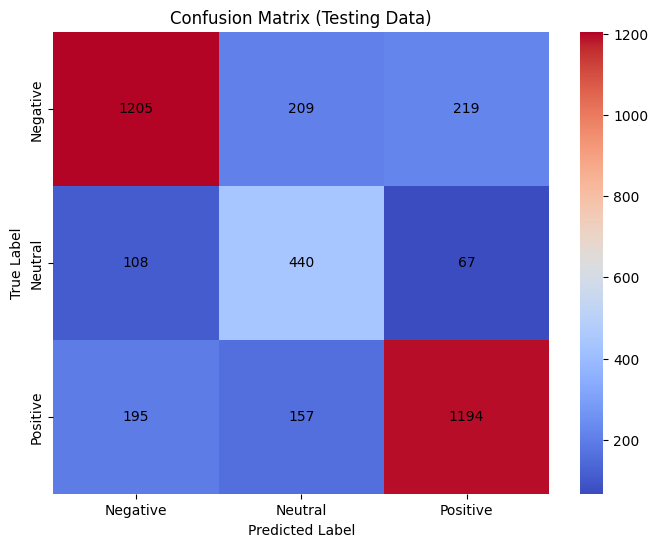

In [51]:
y_pred = grids['LogisticRegression'].predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred)

labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='coolwarm', cbar=True, xticklabels=labels, yticklabels=labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = f"{cm[i, j]}"
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

plt.title('Confusion Matrix (Testing Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

In [52]:
report_dict = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(2)

fig = go.Figure(data=[go.Table(
    header=dict(
        values=['Class'] + list(report_df.columns),
        fill_color='black',
        font=dict(color='white', size=12),
        align='center'
    ),
    cells=dict(
        values=[report_df.index] + [report_df[col] for col in report_df.columns],
        fill_color='black',
        font=dict(color='white', size=12),
        align='center',
        height=25
    )
)])

fig.update_layout(
    title="Classification Report (Testing Data)",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white')
)

fig.show()